# Exercise 4.4

First of all, we import usefull libraries. This exercise is already done.

In [1]:
import math
import numpy as np
import pydot
import copy
from IPython.display import Image

We define some usefull features and values.

In [2]:
class BinaryLeaf:

    def __init__(self, elements, labels, ids):
        self.L = None
        self.R = None
        self.p = None
        self.elements = elements
        self.labels = labels
        self.completed = False
        self.ids = ids

    def set_R(self, Rleaf):
        self.R = Rleaf

    def set_L(self, Lleaf):
        self.L = Lleaf

    def set_elements(self, elements):
        self.elements = elements

    def get_elements(self):
        return self.elements

    def set_p(self, threshold):
        self.p = threshold

    def get_L(self):
        return self.L

    def get_R(self):
        return self.R

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels

    def set_ids(self, ids):
        self.ids = ids

    def get_ids(self):
        return self.ids

labels = [1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1]
data_set = [[1, 1, 2, 2], [2, 1, 2, 2], [1, 1, 1, 2], [1, 2, 1, 2], [2, 3, 2, 2],
            [2, 2, 1, 2], [3, 2, 2, 1], [1, 3, 2, 2], [3, 3, 2, 1], [2, 3, 1, 2],
            [3, 1, 1, 1], [1, 2, 1, 1], [2, 3, 1, 1], [2, 1, 1, 2], [2, 2, 1, 1]]


labels_count = len(np.unique(labels))

ids = list(range(len(data_set)))
root = BinaryLeaf(data_set, labels, ids)
current_node = root
R = 10

# Helper methods:

def compute_v(element, scv):
    return np.sum(np.multiply(element, scv[:-1])) + scv[-1]

def compare_two_leafs(leaf1, leaf2):
    labels1 = leaf1.labels
    labels2 = leaf2.labels
    if len(labels1) == len(labels2):
        for i in range(len(labels1)):
            if labels1[i] != labels2[i]:
                return False
        return True
    return False

def is_leaf_completed(node):
    if node.is_completed():
        if node.get_L() != None and not node.get_L().is_completed():
            return node.get_L()
        elif node.get_R() != None and not node.get_R().is_completed():
            return node.get_R()
        elif node.get_L() == None and node.get_R() == None:
            return None
        elif node.get_L().is_completed() or node.get_R().is_completed():
            new_node = is_leaf_completed(node.get_L())
            if new_node == None:
                return is_leaf_completed(node.get_R())
            else:
                return new_node
        else:
            return None
    return node

# Oc1

def calculate_gini(labels):
    unique_labels = np.unique(labels)
    gini = 0
    for label in unique_labels:
        found = np.where(labels == label)
        gini = gini + len(found)/len(labels)
    return np.square(gini)

def get_all_possible_splits_by_gini(leaf):
    leaf_elements = leaf.elements
    labels = leaf.labels
    ginis = []
    for i in range(len(leaf_elements[0])):
        feature_ginis = []
        feature_column = np.array(leaf_elements)[:, i]
        for feature in feature_column:
            distinguish = feature_column <= feature
            left_labels  = np.array(labels)[distinguish]
            right_labels = np.array(labels)[~distinguish]
            gini = 1 - calculate_gini(left_labels) - calculate_gini(right_labels)
            feature_ginis.append([feature,gini])
        ginis.append(min(feature_ginis))
    return ginis


def find_current_level_data(root):
    return is_leaf_completed(root)

def divide_data_hiperplane(leaf,scv):
    below = []
    above = []
    below_labels = []
    above_labels = []
    below_ids = []
    above_ids = []
    for i in range(len(leaf.elements)):
        v = compute_v(leaf.elements[i],scv) > 0
        if v:
            above.append(leaf.elements[i])
            above_labels.append(leaf.labels[i])
            above_ids.append(leaf.ids[i])            
        else:
            below.append(leaf.elements[i])
            below_labels.append(leaf.labels[i])
            below_ids.append(leaf.ids[i])    
    return np.array(below), np.array(above), np.array(below_labels), np.array(above_labels), below_ids, above_ids

def get_coefficiency(splits):
    splits = np.array(splits)
    scv = np.zeros(len(splits)+1)
    min_split_index = np.argmin(splits[:,1])
    scv[min_split_index] = 1
    scv[-1] = -splits[min_split_index][1]
    return scv

def compute_u(element, scv, feature):
    return (scv[feature] * element[feature] - compute_v(element, scv)) / element[feature]

def sort_u(element):
    return np.sort(element)

def perturb(leaf, scv, feature, old_gini):
    u=[]
    for element in leaf.elements:
        u.append(compute_u(element, scv, feature))
    splits = sort_u(np.array(u))
    am = []
    for split in splits:
        new_scv = scv
        new_scv[feature] = split
        below, above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf, scv)
        gini = 1 - (calculate_gini(below_label) - calculate_gini(above_label))
        am.append([new_scv, gini])
    am = np.array(am)
    best_split_index = np.argmin(am[:,1])
    if am[best_split_index][1] < old_gini:
        return am[best_split_index][1], am[best_split_index][0]
    elif am[best_split_index][1] == old_gini:
        if np.random.random() < 0.3:
            return am[best_split_index][1], am[best_split_index][0]
    return old_gini, scv


def build_level(root, split_history):
    leaf = find_current_level_data(root)
    if leaf == None:
        return
    splits = get_all_possible_splits_by_gini(leaf)
    split_coefficiency_vector = get_coefficiency(splits)
    below,above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf,split_coefficiency_vector)
    gini = 1 - calculate_gini(below_label) - calculate_gini(above_label)
    for c in range(R):
        feature = np.random.randint(0,len(leaf.elements[0])-1)
        gini, split_coefficiency_vector = perturb(leaf, split_coefficiency_vector, feature, gini)
        below, above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf,split_coefficiency_vector)
    left_leaf = BinaryLeaf(below, below_label, below_ids)
    right_leaf = BinaryLeaf(above, above_label, above_ids)
    split_history.append([str(leaf.ids), str(left_leaf.ids)])
    split_history.append([str(leaf.ids), str(right_leaf.ids)])
    leaf.set_completed()

    if len(np.unique(below_label)) == 1:
        left_leaf.set_completed()
    if len(np.unique(above_label)) == 1:
        right_leaf.set_completed()
    if compare_two_leafs(leaf, left_leaf) or compare_two_leafs(leaf,right_leaf):
        leaf.set_completed()
    else:
        leaf.set_R(right_leaf)
        leaf.set_L(left_leaf)
    build_level(root, split_history)
    return root, split_history

def build(root):
    split_history = []
    return build_level(root, split_history)

def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('oc1_tree.png', format='png')

oc1_tree, split_history = build(root)
plot_tree(split_history)

Then, and once we stored the data, we can display the tree.

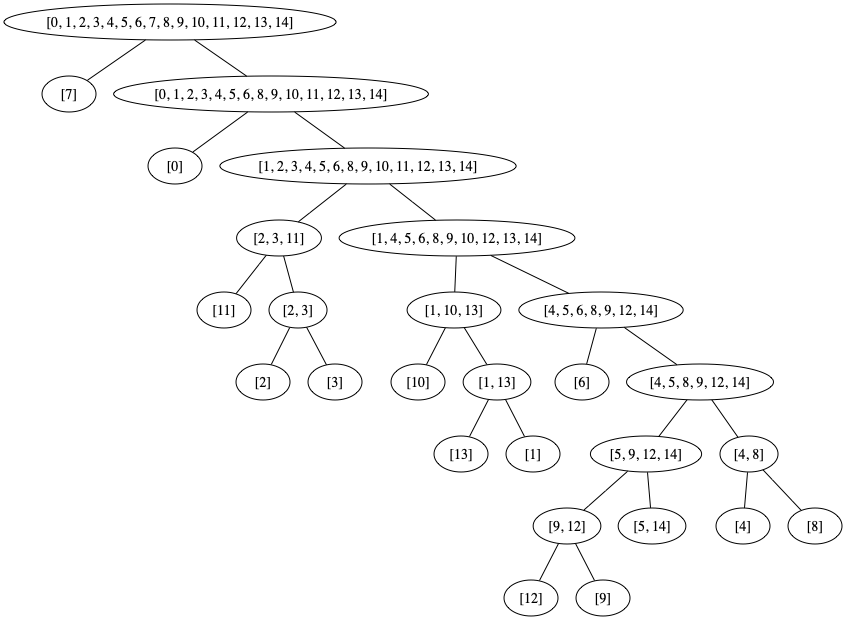

In [3]:
Image(filename = 'oc1_tree.png')